# RandomForest and FeatureEngineering to predict Uptake of Vaccines

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer

In [2]:
df = pd.read_csv('training_set_features[1].csv')
df_ = pd.read_csv('training_set_labels[1].csv')

In [3]:
y = df_.drop(columns=['respondent_id'])

<Axes: >

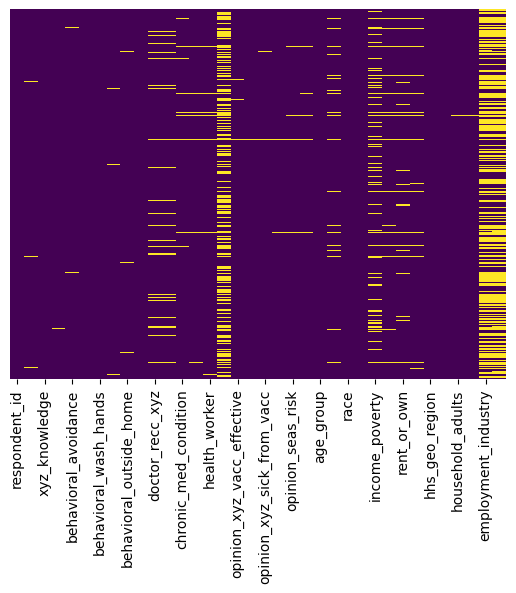

In [4]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [5]:
df.isnull().sum()

respondent_id                      0
xyz_concern                       92
xyz_knowledge                    116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_xyz                 2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_xyz_vacc_effective       391
opinion_xyz_risk                 388
opinion_xyz_sick_from_vacc       395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

In [6]:
def feature_engineering(df):

    #removing features that are not very relevent
    features = df.drop(columns=['respondent_id', 'hhs_geo_region', 'employment_industry', 'employment_occupation', 'health_insurance', 'behavioral_antiviral_meds'])

    #Since most of the features are either either classifier or ordinal, rating them will even reduce the effort to scale each feature
    education_order = {
        '< 12 Years': 0,
        '12 Years': 1,
        'Some College': 2,
        'College Graduate': 3,
    }
    features['education'] = features['education'].map(education_order)

    sex_code = {
        'Male': 0,
        'Female': 1,
    }
    features['sex'] = features['sex'].map(sex_code)

    age_order = {
        '18 - 34 Years': 0,
        '35 - 44 Years': 1,
        '45 - 54 Years': 2,
        '55 - 64 Years': 3,
        '65+ Years': 4,
    }
    features['age_group'] = features['age_group'].map(age_order)
    
    income_order = {
        'Below Poverty': 0,
        '<= $75,000, Above Poverty': 1,
        '> $75,000': 2,
    }
    features['income_poverty'] = features['income_poverty'].map(income_order)
    
    marital_code = {
        'Not Married': 0,
        'Married': 1,
    }
    features['marital_status'] = features['marital_status'].map(marital_code)
    
    own_code = {
        'Rent': 0,
        'Own': 1,
    }
    features['rent_or_own'] = features['rent_or_own'].map(own_code)

    #adding the features to reduce overfitting and too many features to handle
    features['household_members'] = features['household_adults'] + features['household_children']
    features = features.drop(columns=['household_adults', 'household_children'])
    features['gathering'] = features['behavioral_large_gatherings'] + features['behavioral_outside_home']
    features = features.drop(columns=['behavioral_large_gatherings', 'behavioral_outside_home'])

    #categorizing the left-out features using one-hot encoding
    categorical_features = ['race', 'employment_status', 'census_msa']
    features = pd.get_dummies(features, columns=categorical_features, drop_first=True)

    #making all the feature float type to maintain uniformity
    features = features.astype(float)

    #filling the missing values with mode
    X = features.apply(lambda x: x.fillna(x.mode()[0]), axis=0)

    return X

In [7]:
X = feature_engineering(df)

In [8]:
def predict(X_test):
    y_pred_proba_1 = rf1.predict_proba(X_test)
    y_pred_proba_2 = rf2.predict_proba(X_test)
    df1 = pd.DataFrame(y_pred_proba_1[:, 1], columns=['xyz_vaccine'])
    df2 = pd.DataFrame(y_pred_proba_2[:, 1], columns=['seasonal_vaccine'])
    y = pd.concat([df1, df2], axis=1)
    return y

In [9]:
y.head()

,xyz_vaccine,seasonal_vaccine
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0


In [10]:
y1 = pd.DataFrame(y['xyz_vaccine'])
y2 = pd.DataFrame(y['seasonal_vaccine'])

In [11]:
X_train, X_testt, y_train_1, y_test_1 = train_test_split(X, y1, test_size=0.33, random_state=89)
X_train, X_testt, y_train_2, y_test_2 = train_test_split(X, y2, test_size=0.33, random_state=89)

In [12]:
rf1 = RandomForestClassifier(n_estimators=100, random_state=89)
rf2 = RandomForestClassifier(n_estimators=100, random_state=89)

In [13]:
rf1.fit(X_train, y_train_1)
rf2.fit(X_train, y_train_2)

C:\Users\aarus\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\aarus\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(random_state=89)

In [14]:
importances = rf1.feature_importances_
feature_names = X_train.columns
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print(feature_importances)

                                 Feature  Importance
6                        doctor_recc_xyz    0.109752
12                      opinion_xyz_risk    0.077905
11            opinion_xyz_vacc_effective    0.064014
17                             age_group    0.052178
15                     opinion_seas_risk    0.050214
23                     household_members    0.049899
13            opinion_xyz_sick_from_vacc    0.042841
0                            xyz_concern    0.041940
18                             education    0.039922
16           opinion_seas_sick_from_vacc    0.039501
14           opinion_seas_vacc_effective    0.036331
24                             gathering    0.033487
1                          xyz_knowledge    0.030912
20                        income_poverty    0.028717
7                   doctor_recc_seasonal    0.025661
19                                   sex    0.024006
10                         health_worker    0.022524
30        census_msa_MSA, Principle City    0.

In [15]:
y_pred_proba_1 = rf1.predict_proba(X_testt)
y_pred_proba_2 = rf2.predict_proba(X_testt)

In [16]:
y_pred_proba_1

array([[0.79, 0.21],
       [0.72, 0.28],
       [0.79, 0.21],
       ...,
       [0.25, 0.75],
       [0.84, 0.16],
       [0.4 , 0.6 ]])

In [17]:
y_pred_proba_2

array([[0.79, 0.21],
       [0.06, 0.94],
       [0.36, 0.64],
       ...,
       [0.3 , 0.7 ],
       [0.6 , 0.4 ],
       [0.5 , 0.5 ]])

In [18]:
y_test_1.head()

,xyz_vaccine
7660,0
18593,0
14408,0
875,0
24179,0


In [19]:
def convert(y_test, y_pred_proba):

    if isinstance(y_test, pd.DataFrame):
        y_test = y_test.iloc[:, 0]  # Select the first column if it's a DataFrame
    elif isinstance(y_test, np.ndarray) and y_test.ndim == 2:
        y_test = y_test[:, 0]  # Select the first column if it's a 2D array
    
    if isinstance(y_pred_proba, pd.DataFrame):
        y_pred_proba = y_pred_proba.iloc[:, 1]  # Select the second column
    elif isinstance(y_pred_proba, np.ndarray) and y_pred_proba.ndim == 2:
        y_pred_proba = y_pred_proba[:, 1]  # Select the second column

    return y_test, y_pred_proba

In [20]:
y_test_1, y_pred_proba_1 = convert(y_test_1, y_pred_proba_1)
y_test_2, y_pred_proba_2 = convert(y_test_2, y_pred_proba_2)

In [21]:
roc_auc_1 = roc_auc_score(y_test_1, y_pred_proba_1) 
roc_auc_1

0.8165720754462754

In [22]:
roc_auc_2 = roc_auc_score(y_test_2, y_pred_proba_2) 
roc_auc_2

0.8442662998609708

In [23]:
df1 = pd.DataFrame(y_pred_proba_1, columns=['prob_1'])
df2 = pd.DataFrame(y_pred_proba_2, columns=['prob_2'])
y = pd.concat([df1, df2], axis=1)
y

,prob_1,prob_2
0,0.21,0.21
1,0.28,0.94
2,0.21,0.64
3,0.05,0.12
4,0.05,0.94
...,...,...
8809,0.22,0.24
8810,0.04,0.12
8811,0.75,0.70
8812,0.16,0.40


In [24]:
def my_model(X_test):
    X = feature_engineering(X_test)
    y = predict(X)
    return y

## Applying the model featured above

In [25]:
final_test_set = pd.read_csv('test_set_features[1].csv')

In [26]:
X = feature_engineering(final_test_set)
y = my_model(final_test_set)

In [27]:
y

,xyz_vaccine,seasonal_vaccine
0,0.10,0.32
1,0.02,0.00
2,0.44,0.85
3,0.53,0.80
4,0.23,0.46
...,...,...
26703,0.45,0.50
26704,0.17,0.32
26705,0.08,0.25
26706,0.07,0.25


In [28]:
output_file_path = 'submission_format[1].xlsx'
y.to_excel(output_file_path, index=False)
print(f"DataFrame saved to {output_file_path}")

DataFrame saved to submission_format[1].xlsx
